# A spectral-cube guide for CASA users #

## Authors ##
[Eric Koch](https://github.com/e-koch), [Adam Ginsburg](https://github.com/keflavich), [Tom Robitaille](https://github.com/astrofrog)

## Summary ##

This tutorial demonstrates how equivalent operations in spectral-cube and CASA for users familiar with CASA.

*Note: This tutorial shows only basic uses of CASA tasks and tools. For a full list of capabilities, see the [CASA documentation](https://casa.nrao.edu/casadocs).*

The spectral-cube operations will be demonstrated with dask enabled (see [the docs page](https://spectral-cube.readthedocs.io/en/latest/dask.html) on dask integration).

## Learning goals ##

* Using dask with spectral-cube
* Cube statistics
* Moment maps
* Spectral fitting
* Spatial fitting

## Keywords ##

radio astronomy, spectral-line data cubes, CASA

## Requires ##

*NOTE: this tutorial requires CASA 6 to be installed. Tested for versions up to CASA 6.1.*

```
pip install astropy
pip install spectral-cube
pip install radio-beam
pip install dask
pip install aplpy
pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools
pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks
```


In [177]:
%matplotlib inline

from pathlib import Path
from time import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting

from spectral_cube import SpectralCube

# Uncomment to create a progress bar for all dask operations.
# Disabled here as it increases the run time significantly for this small cube.
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

Below, we import the relevant `casatools` and `casatasks`.

In [178]:
from casatasks import imfit, immoments, specfit
from casatools import image

# Load the image tool
ia = image()

For this tutorial, we will download a small region of M33 tracing the CO(2-1) molecular line transition. This is a region taken from a larger ALMA mosaic observed with the ACA (Morita) 7-m array (Project ID: 2019.1.01182.S).

In [241]:
from astropy.utils.data import download_file

datafile = download_file(
    'https://zenodo.org/record/4050489/files/M33_ALMA_ACA_12CO21.cutout.fits',
    cache=True, show_progress=True)

# Note that the datafile will not end in ".fits". Because of that, we need to specify the format
# When the file name end in "fits", `format` will not need to be specified 
cube = SpectralCube.read(datafile, format='fits', use_dask=True)

# Convert to km/s for the spectral unit
cube = cube.with_spectral_unit(u.km / u.s)

## Cube statistics ##

Both CASA and spectral-cube have a convienience function for computing common statistics for the entire data cube.

In CASA, this is `ia.statistics`, while in spectral-cube, this is `SpectralCube.statistics` (note that this is currently defined only for a `DaskSpectralCube`, like what we use here).


In [180]:
t0 = time()

ia.open(filename)
out = ia.statistics()
ia.done()
ia.close()

t1 = time()

time_casa_cubestats = t1 - t0

print(f"CASA cube statistics time: {time_casa_cubestats} s")
print(out)

CASA cube statistics time: 0.04432868957519531 s
{'blc': array([0, 0, 0], dtype=int32), 'blcf': '01:33:42.875, +30.45.02.035, 2.307533e+11Hz', 'flux': array([2844.71940991]), 'max': array([1.97525465]), 'maxpos': array([63, 58, 89], dtype=int32), 'maxposf': '01:33:37.987, +30.46.00.020, 2.307075e+11Hz', 'mean': array([0.00345528]), 'min': array([-1.35735619]), 'minpos': array([ 63,  62, 222], dtype=int32), 'minposf': '01:33:37.987, +30.46.04.020, 2.306389e+11Hz', 'npts': array([1228800.]), 'rms': array([0.11577152]), 'sigma': array([0.11571999]), 'sum': array([4245.84986529]), 'sumsq': array([16469.66037369]), 'trc': array([ 63,  63, 299], dtype=int32), 'trcf': '01:33:37.987, +30.46.05.020, 2.305993e+11Hz'}


In [181]:
t0 = time()

out_sc = cube.statistics()

t1 = time()

time_sc_cubestats = t1 - t0

print(f"SC cube statistics time: {time_sc_cubestats} s")
print(out_sc)

SC cube statistics time: 0.0683283805847168 s
{'npts': 1228800.0, 'min': <Quantity -1.35735625 K>, 'max': <Quantity 1.97525464 K>, 'sum': <Quantity 4245.84985979 K>, 'sumsq': <Quantity 16469.66037109 K2>, 'mean': <Quantity 0.00345528 K>, 'sigma': <Quantity 0.11571999 K>, 'rms': <Quantity 0.11577152 K>}


For this small cube, both CASA and spectral-cube have a similar performance.

## Moment maps ##

Moment maps are a common method used to analyze the signal in a spectral-line data cube. Typically, the first few moments calculated along the spectral dimensions have the information required for most analyses. These are defined as:

* Moment 0: The integrated intensity in each spectrum. The units are the cube's brightness units multiplied by the spectral unit (e.g., K km/s).
* Moment 1: The intensity weighted centroid along a spectrum. The units are in the spectral dimension in the cube (e.g., km/s or GHz).
* Moment 2: The intensity weighted dispersion along a spectrum. The square root estimates the line width. The units are in the spectral dimension in the cube (e.g., km/s or GHz).
* Peak intensity: The maximum in each spectrum. The units are the dimensions of the cube (e.g., K or Jy/beam)
* Peak velocity: The spectral position of the maximum along a spectrum (i.e., the peak of a spectrum). The units are in the spectral dimension in the cube.

Here we show the equivalent calls in spectral-cube and CASA to produce these moment maps.


### Moment 0 ###

In CASA, moment maps can be made in two ways: `immoments` (task level) and `ia.moments` (tool level). Both provide the ability to compute different types of moment maps.

While the `immoments` task is likely the most common method to use, we will use `ia.moments` in this tutorial since it does not immediately save the moment map to a CASA image file. The equivalent calls for `immoments` are also shown.

To produce the zeroth moment map:

In [182]:
# Using `immoments`
# immoments(filename, moments=0, axis='spec',
#           outfile=outfilename)

t0 = time()

ia.open(filename)
moment0 = ia.moments(moments=0, drop=True)
ia.done()
ia.close()

t1 = time()

time_casa_moment0 = t1 - t0

print(f"CASA cube moment 0 time: {time_casa_moment0} s")

CASA cube moment 0 time: 0.2225022315979004 s


There is one difference in how CASA saves the moment maps with respect to the original FITS file and how spectral-cube creates moment maps. The array from the CASA output will have the axes transposed with respect to the original FITS file.

We will tranpose the axes here and for the other CASA-derived moment maps below.

In [183]:
# Image as a numpy array
casa_moment0 = moment0.getchunk()

# Close the CASA image
moment0.done()
moment0.close()

casa_moment0 = casa_moment0.T

In spectral-cube, there is a generic `SpectralCube.moment` function, and a separate `SpectralCube.moment0` function for convenience. The former just requires specifying the order of the moment.

In [184]:
# Using the general moment function:
# sc_moment0 = cube.moment(order=0)

t0 = time()

sc_moment0 = cube.moment0()
t1 = time()


time_sc_moment0 = t1 - t0

print(f"SC cube moment0 time: {time_sc_moment0} s")

SC cube moment0 time: 0.18993401527404785 s


Here are the equivalent moment 0 maps from both CASA and spectral-cube:

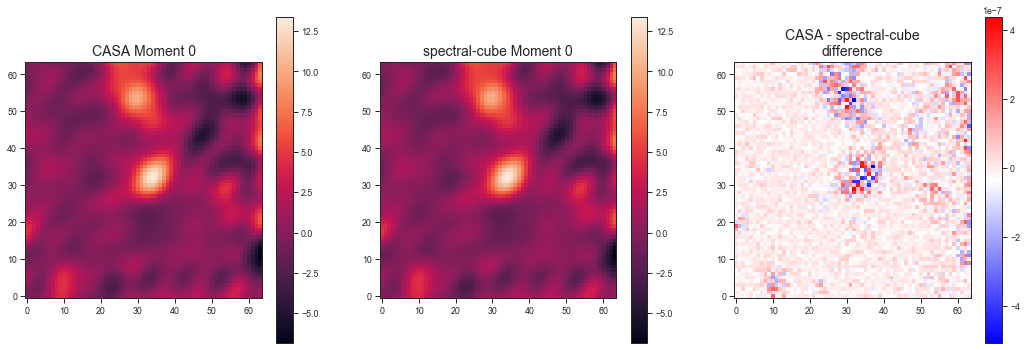

In [231]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("CASA Moment 0", fontsize=14)
plt.imshow(casa_moment0, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("spectral-cube Moment 0", fontsize=14)
plt.imshow(sc_moment0.value, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("CASA - spectral-cube\ndifference", fontsize=14)
plt.imshow(casa_moment0 - sc_moment0.value, origin='lower', cmap='bwr')
plt.colorbar()



The moment 0 maps are effectively equivalent. The ~1e-7 differences are likely due to floating point roundoff.

When the cube has a varying beam (per spectral channel), differences in moment maps may also arise from differences between spectral-cube and CASA in how those beams are treated. spectral-cube checks for and allows operations when there are small variations in the beams (<1%`), and otherwise raises an error if the beams are too discrepant. CASA will automatically convolve each channel to the largest beam in the set of beams when computing the moment map.

### A note on masking ###

With increasing order, the moment maps become more susceptible to noise in the cube. Because of this, it becomes necessary to impose a signal mask to exclude regions without signal from the moment maps.

For this example, we will impose a simple mask based on the moment 0 maps above. There are 2 clear sources of signal in the above maps, and we will impose a spatial mask based on a threshold of the integrated intensity.

**Note: You may notice a bright peak in the peak intensity map below. The cube we use in this tutorial is near the edge of the larger mosaic observed by ALMA. This apparent "peak" is due to the low primary beam coverage at this point and therefore is noisier.**

See [ADD LINK TO MASKING TUTORIAL]() for examples of more sophisticated masking techniques.

In [222]:
spatial_mask = sc_moment0 > 8 * u.K * u.km / u.s

masked_cube = cube.with_mask(spatial_mask)

# TODO: try to add the mask directly to the CASA calls

### Moment 1 ###

In CASA:

In [187]:
# Using `immoments`
# immoments(filename, moments=1, axis='spec',
#           outfile=outfilename)

t0 = time()

ia.open(filename)
moment1 = ia.moments(moments=1, drop=True)
ia.done()
ia.close()

t1 = time()

time_casa_moment1 = t1 - t0

print(f"CASA cube moment 1 time: {time_casa_moment1} s")

# Image as a numpy array
casa_moment1 = moment1.getchunk()

# Close the CASA image
moment1.done()
moment1.close()

casa_moment1 = casa_moment1.T

casa_moment1[~spatial_mask] = np.NaN


CASA cube moment 1 time: 0.17294859886169434 s


In spectral-cube:

In [188]:
# Using the general moment function:
# sc_moment1 = cube.moment(order=1)

t0 = time()

sc_moment1 = masked_cube.moment1()
t1 = time()


time_sc_moment1 = t1 - t0

print(f"SC cube moment1 time: {time_sc_moment1} s")

SC cube moment1 time: 0.9591319561004639 s


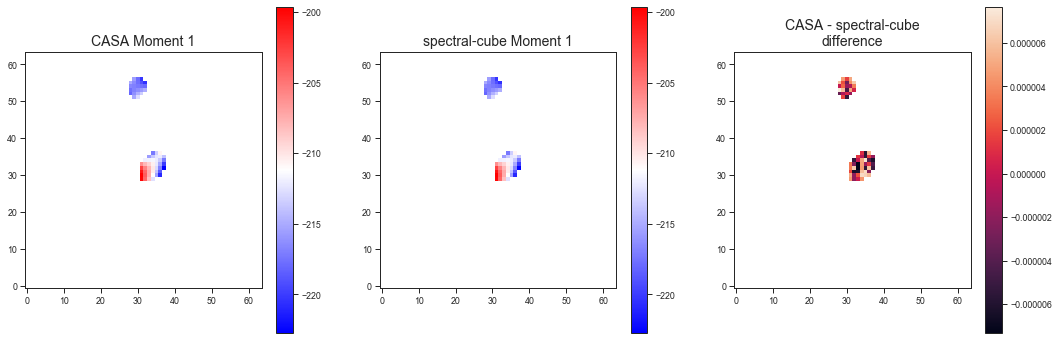

In [189]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("CASA Moment 1", fontsize=14)
plt.imshow(casa_moment1, origin='lower', cmap='bwr')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("spectral-cube Moment 1", fontsize=14)
plt.imshow(sc_moment1.value, origin='lower', cmap='bwr')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("CASA - spectral-cube\ndifference", fontsize=14)
plt.imshow(casa_moment1 - sc_moment1.value, origin='lower', cmap='bwr')
plt.colorbar()



As with the moment 0 maps, the two moment 1 maps are essentially identical.

Note that the channel widths in the cube are 0.7 km/s. The differences between the CASA and spectral-cube moment 1 maps is again negligible. 

### Moment 2 and line width ###

The second moment map is the variance. Because of this, we are usually intrested in its square root---effectively the standard deviation. For a Gaussian line profile with very high signal-to-noise ratio, this standard deviation will be the line of the Gaussian.

The moment 2 map in CASA is actually the line width, or the square root of the formal definition of the second moment. Because of this, no additional square root operation is needed.

In [223]:
# Using `immoments`
# immoments(filename, moments=2, axis='spec',
#           outfile=outfilename)

t0 = time()

ia.open(filename)
moment2 = ia.moments(moments=2, drop=True)
ia.done()
ia.close()

t1 = time()

time_casa_moment2 = t1 - t0

print(f"CASA cube moment 2 time: {time_casa_moment2} s")

# Image as a numpy array
casa_moment2 = moment2.getchunk()

# Close the CASA image
moment2.done()
moment2.close()

casa_moment2 = casa_moment2.squeeze()
casa_moment2 = casa_moment2.T

casa_moment2[~spatial_mask] = np.NaN


CASA cube moment 2 time: 0.12764477729797363 s


In spectral-cube, the moment 2 map is the formal definition equivalent to the variance. Therefore, it has units of the spectral dimension squared (e.g., (km/s)^2).

The moment 2 is computed in the same way as shown above for the moment 1 map.

However, in most cases, the square root of the second moment is of interest, or the equivalent to what CASA returns as the second moment. There are two functions to return the line width: one to return the Gaussian `sigma` (`SpectralCube.linewidth_sigma`) and the full-width-half-max (FWHM; `SpectralCube.linewidth_fwhm`). The former is equivalent to the definition used in CASA.

First, to compute only the moment 2 map:

In [224]:
# Using the general moment function:
# sc_moment2 = cube.moment(order=2)

t0 = time()

sc_moment2 = masked_cube.moment2()
t1 = time()


time_sc_moment2 = t1 - t0

print(f"SC cube moment2 time: {time_sc_moment2} s")

SC cube moment2 time: 0.23845148086547852 s


And to directly compute the line width:

In [225]:
lwidth_sigma = masked_cube.linewidth_sigma()  # Equivalent to CASA's 2nd moment

lwidth_fwhm = masked_cube.linewidth_fwhm()

`lwidth_sigma` and `lwidth_fwhm` differ only by a factor of $\sqrt{8 {\rm ln} 2}$ (~2.35).

Here, we plot the equivalent "line width sigma" to compare between CASA and spectral-cube:

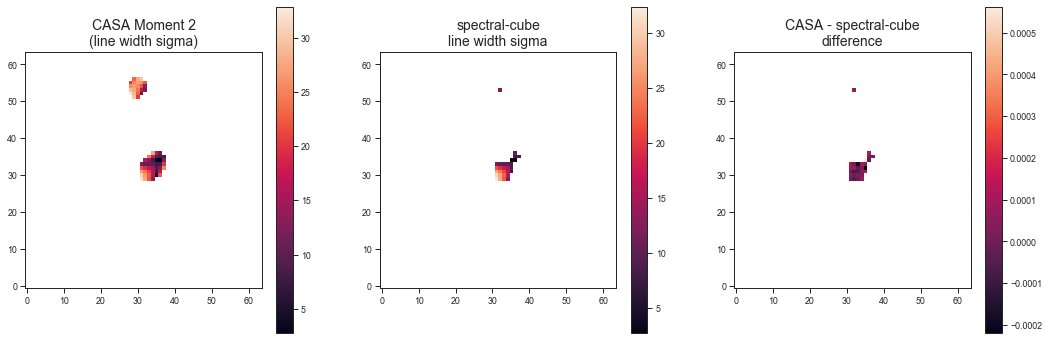

In [226]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("CASA Moment 2\n(line width sigma)", fontsize=14)
plt.imshow(casa_moment2, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("spectral-cube\nline width sigma", fontsize=14)
plt.imshow(lwidth_sigma.value, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("CASA - spectral-cube\ndifference", fontsize=14)
plt.imshow(casa_moment2 - lwidth_sigma.value, origin='lower', cmap='bwr')
plt.colorbar()



The values agree well between the CASA moment 2 and spectral'cube line width sigma. However, there are noticably fewer finite values in the spectral-cube version.

The difference is due to how negative values are handled in the moment 2 (variance) map. When only signal is present, the moment 2 values should all be positive since the intensity will be positive.
However, negative moment 2 values can be produced when noise is present and some intensity values are <0. In CASA, `immoments` takes the absolute value of the moment 2 variance before applying the square root. spectral-cube does not make this assumption, and so the additional NaN values above are due to places where the moment 2 value was negative.

To exactly reproduce the CASA behaviour, the following can be compared:

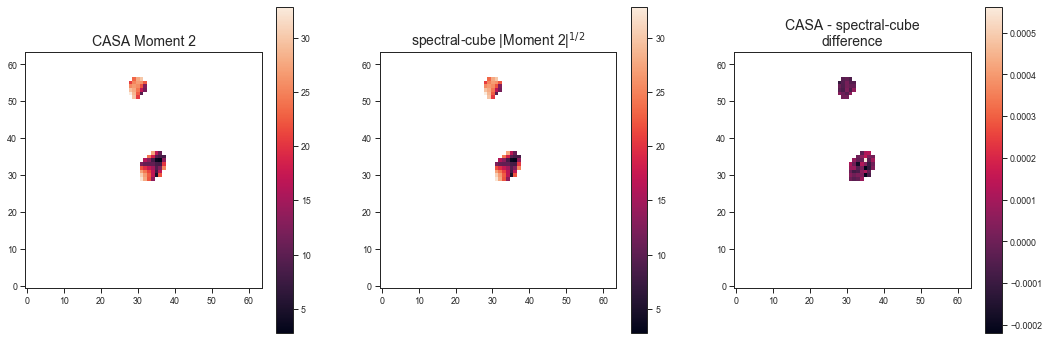

In [227]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("CASA Moment 2", fontsize=14)
plt.imshow(casa_moment2, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("spectral-cube |Moment 2|$^{1/2}$", fontsize=14)
plt.imshow(np.sqrt(np.abs(sc_moment2.value)), origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("CASA - spectral-cube\ndifference", fontsize=14)
plt.imshow(casa_moment2 - np.sqrt(np.abs(sc_moment2.value)), origin='lower', cmap='bwr')
plt.colorbar()



Now the two match exactly.

**Note:** When the moment 2 map has a negative value, it likely means additional masking is necessary. Taking the absolute value of the second moment map is equivalent to taking the absolute value of the spectrum, which is not representative of the noise properties and, critically, **will lead to an overestimate of the line width from the second moment.**

In this simple example, we applied only a spatial mask and left some noisy regions along the spectral dimension. From the moment 1 maps above, we know that most of the signal is around -190 to -230 km/s. Using only that range, the line width map is:

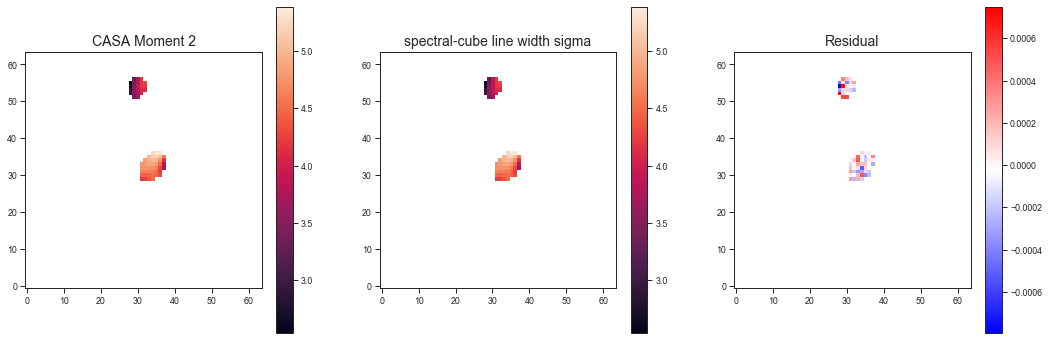

In [230]:
# Using a spectral range in CASA

# Get the pixel range of the velocity range
low_chan = cube.closest_spectral_channel(-230 * u.km / u.s)
high_chan = cube.closest_spectral_channel(-190 * u.km / u.s)

outfilename = f"{filename.split('.')[0]}.moment2.image"

if not os.path.exists(outfilename):
    immoments(filename, moments=2, axis='spec',
              outfile=outfilename,
            #   mask=f'"{filename}">0.12',  # Mask out noise
              chans=f'{low_chan}~{high_chan}', # Spectral slab where the signal is located
              )

# Image as a numpy array
ia.open(outfilename)
casa_moment2_slab = ia.getchunk().squeeze()

# Close the CASA image
ia.done()
ia.close()

casa_moment2_slab = casa_moment2_slab.T

casa_moment2_slab[~spatial_mask] = np.NaN

# Using a spectral range in spectral-cube

lwidth_sigma_slab = masked_cube.spectral_slab(-190 * u.km / u.s, -230 * u.km / u.s).linewidth_sigma()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("CASA Moment 2", fontsize=14)
plt.imshow(casa_moment2_slab, origin='lower')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("spectral-cube line width sigma", fontsize=14)
plt.imshow(lwidth_sigma_slab.value, origin='lower')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual", fontsize=14)
plt.imshow(casa_moment2_slab - lwidth_sigma_slab.value, origin='lower', cmap='bwr')
plt.colorbar()

Note that the line widths with the spectral masking are now **~5 times smaller**. Because the moment 2 map is a measure of variance, noisy values far from the moment 1 (centroid) value can cause an large overestimation in the line width.

### Peak intensity ###

The peak intensity is simply the maximum along each spectrum.

*Note: We use the cube without the spatial mask applied above. Bright signal will be evident, though a mask may be helpful when the peak signal-to-noise in the cube is small.*

In CASA, this is defined as `moments=8`. This is simply the setting used in CASA and is not a formal definition for the 8th moment (which is not used in practice, anyways).

In [197]:
# Using `immoments`
# immoments(filename, moments=8, axis='spec',
#           outfile=outfilename)

t0 = time()

ia.open(filename)
moment8 = ia.moments(moments=8)
ia.done()
ia.close()

t1 = time()

time_casa_peak = t1 - t0

print(f"CASA cube peak intensity time: {time_casa_peak} s")

# Image as a numpy array
casa_peakintensity = moment8.getchunk()

# Close the CASA image
moment8.done()
moment8.close()

casa_peakintensity = casa_peakintensity.squeeze()
casa_peakintensity = casa_peakintensity.T



CASA cube peak intensity time: 0.18326807022094727 s


In spectral-cube, the `SpectralCube.max` operation can be applied along the spectral dimension (`axis=0`):

In [198]:
t0 = time()

sc_peakintensity = cube.max(axis=0)

t1 = time()


time_sc_peak = t1 - t0

print(f"SC cube peak time: {time_sc_peak} s")

SC cube peak time: 0.03095269203186035 s


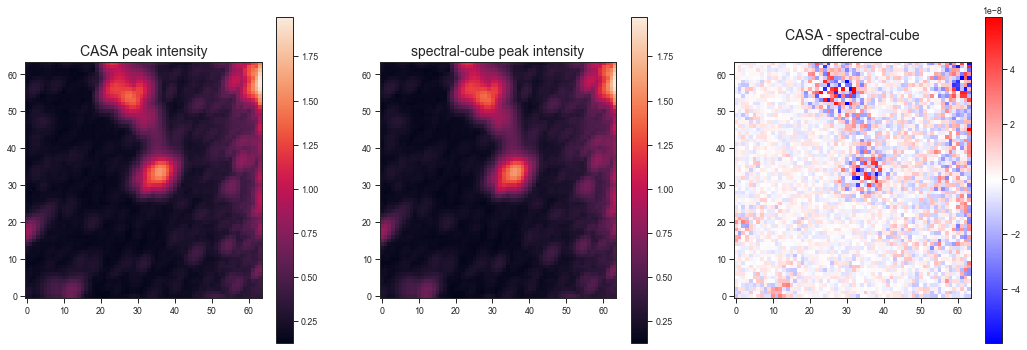

In [232]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("CASA peak intensity", fontsize=14)
plt.imshow(casa_peakintensity, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("spectral-cube peak intensity", fontsize=14)
plt.imshow(sc_peakintensity.value, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("CASA - spectral-cube\ndifference", fontsize=14)
plt.imshow(casa_peakintensity - sc_peakintensity.value, origin='lower', cmap='bwr')
plt.colorbar()


We clearly see two bright sources in the above peak intensity maps, along with possibly fainter signal bridging between the two. This fainter signal requires a more careful signal mask to derive its properties in the signal mask.

Also, as noted above, the apparent bright peak in the upper right corner is where the noise increases at the edge of the observed mosaic, and is therefore not real signal.

### Peak velocity ###

The peak velocity is the velocity (or equivalent spectral unit) where the peak intensity is located. Since this is only well-defined where signal is detected, we will use the masked cube again for this example.


In CASA, the peak velocity is defined as `moments=9`, which similar to the peak intensity, is the label used for `immoments` or `ia.moments`.


In [200]:
# Using `immoments`
# immoments(filename, moments=9, axis='spec',
#           outfile=outfilename)

t0 = time()

ia.open(filename)
moment9 = ia.moments(moments=9)
ia.done()
ia.close()

t1 = time()

time_casa_peakvelocity = t1 - t0

print(f"CASA cube peak velocity time: {time_casa_peakvelocity} s")

# Image as a numpy array
casa_peakvelocity = moment9.getchunk()

# Close the CASA image
moment9.done()
moment9.close()

casa_peakvelocity = casa_peakvelocity.squeeze()
casa_peakvelocity = casa_peakvelocity.T

casa_peakvelocity[~spatial_mask] = np.NaN


CASA cube peak velocity time: 0.19338464736938477 s


In spectral-cube, the velocity at peak intensity can be computed with the `SpectralCube.argmax_world(axis=0)` function. This function will convert the pixel values from `SpectralCube.argmax` to the WCS coordinates along the given axis. Specifying `axis=0` will use the spectral axis and so will return the peak velocity.

In [201]:
t0 = time()

sc_peakvelocity = masked_cube.argmax_world(axis=0)

t1 = time()


time_sc_peakvel = t1 - t0

print(f"SC cube peak velocity time: {time_sc_peakvel} s")

AttributeError: 'DaskSpectralCube' object has no attribute 'argmax_world'

In [202]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("CASA peak velocity", fontsize=14)
plt.imshow(casa_peakvelocity, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("spectral-cube peak velocity", fontsize=14)
plt.imshow(sc_peakvelocity.value, origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("CASA - spectral-cube\ndifference", fontsize=14)
plt.imshow(casa_peakvelocity - sc_peakvelocity.value, origin='lower', cmap='bwr')
plt.colorbar()


NameError: name 'sc_peakvelocity' is not defined

## Fitting ##

Spectral and spatial fits are common operations on spectral-cubes. In [ADD FITTING TUTORIAL]() we demonstrate how to use [astropy.modeling](https://docs.astropy.org/en/stable/modeling/) with spectral-cube. We will use the models described in that tutorial here to compare with the CASA tasks for fitting.

### Spectral fitting ###

To demonstrate fitting in both spectral-cube and CASA, we will fit a single spectrum with a high signal-to-noise to a Gaussian model.


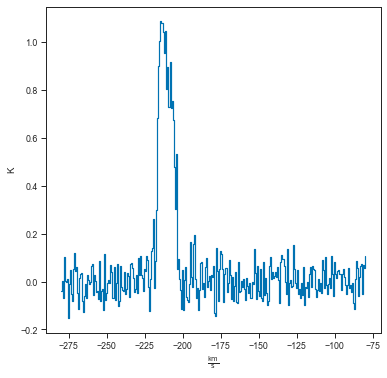

In [203]:
y, x = 32, 32

plt.figure(figsize=(6, 6))

spec = cube[:, y, x]
spec.quicklook()

Spectral fitting in CASA uses the [`specfit` task](https://casa.nrao.edu/casadocs/casa-6.1.0/global-task-list/task_specfit/about).

In [233]:
t0 = time()

specfit_casa = specfit(imagename=filename, ngauss=1, box=f'{x-1},{y-1},{x},{y}', wantreturn=True)

t1 = time()

print(f"CASA specfit time: {t1 - t0} s")


# Note that FWHM needs to be converted to "sigma" (FWHM = sqrt(8 ln 2) sigma).
FWHM2SIGMA = np.sqrt(8 * np.log(2))

# Produce an astropy model with the fitted parameters
# The "squeeze" operations are to reduce the CASA fit output to a 1D array
g_casafit = models.Gaussian1D(amplitude=specfit_casa['gs']['amp'].squeeze() * u.K,
                              mean=specfit_casa['gs']['center'].squeeze() * u.km / u.s,
                              stddev=specfit_casa['gs']['fwhm'].squeeze() / FWHM2SIGMA * u.km / u.s)
print(g_casafit)


CASA specfit time: 0.10179424285888672 s
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean             stddev     
            K                 km / s            km / s     
    ------------------ ------------------- ----------------
    0.9730499168547999 -211.32583082067916 4.23612897618181


`specfit` has many additional parameters and settings, including fitting multiple spectra, which are not shown for this example.

The equivalent fitting with spectral-cube and astropy is:

In [234]:
t0 = time()

# The 1D Gaussian model with initial guesses for parameters
g_init = models.Gaussian1D(amplitude=1.0 * u.K, mean=-210 * u.km / u.s, stddev=4. * u.km / u.s)

# And fit with the Levenberg-Marquardt algorithm and least squares statistic.
fit_g = fitting.LevMarLSQFitter()

# The initial model, spectral axis (in km/s) and spectrum are passed for the fit
g_fit = fit_g(g_init, spec.spectral_axis, spec)

t1 = time()

print(f"SC/astropy spectral fit time: {t1 - t0} s")

print(g_fit)

SC/astropy spectral fit time: 0.010543346405029297 s
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
            K                 km / s             km / s     
    ------------------ ------------------- -----------------
    1.0974570268801327 -211.55635877059825 4.187827787198793


Text(0.5, 0, 'Velocity (km/s)')

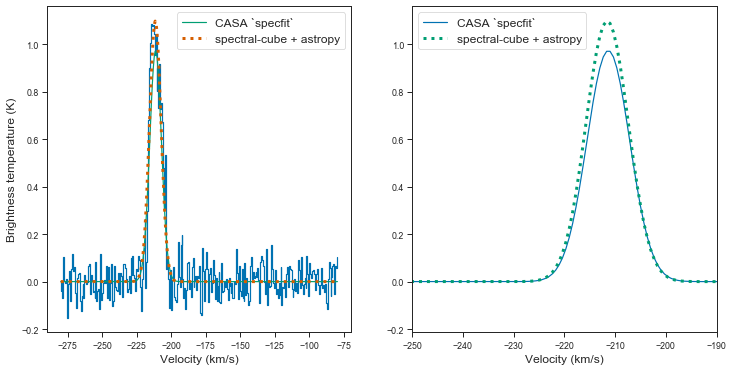

In [206]:
plt.figure(figsize=(12, 6))

ax0 = plt.subplot(1, 2, 1)

spec.quicklook()

plt.plot(spec.spectral_axis, g_casafit(spec.spectral_axis), label='CASA `specfit`')
plt.plot(spec.spectral_axis, g_fit(spec.spectral_axis), ":",
         label='spectral-cube + astropy', linewidth=3)
plt.legend(frameon=True, loc='upper right', fontsize=12)

plt.ylabel("Brightness temperature (K)", fontsize=12)
plt.xlabel("Velocity (km/s)", fontsize=12)

plt.subplot(1, 2, 2, sharey=ax0)

plt.plot(spec.spectral_axis, g_casafit(spec.spectral_axis), label='CASA `specfit`')
plt.plot(spec.spectral_axis, g_fit(spec.spectral_axis), ":",
         label='spectral-cube + astropy', linewidth=3)
plt.legend(frameon=True, loc='upper left', fontsize=12)

plt.xlim([-250, -190])

plt.xlabel("Velocity (km/s)", fontsize=12)


The result fits are quite similar with only a small difference in the amplitudes.

### Spatial fitting ###

Similar to the spectral fitting, we will demonstrate spatial fitting to a single source in the integrated intensity (moment 0) map with a 2D Gaussian model.

In CASA, 2D Gaussians can be fit using the [`imfit` task](https://casa.nrao.edu/casadocs/casa-6.1.0/global-task-list/task_imfit/about).

In [236]:
# Create a new moment0 image
outfilename = f"{filename.split('.')[0]}.moment0.image"

# Cutout a 13 pixel box around the central source
size = 13

# Identify the spectral channels. We will only integrate over the range where
# there is bright signal
low_chan = cube.closest_spectral_channel(-230 * u.km / u.s)
high_chan = cube.closest_spectral_channel(-190 * u.km / u.s)

if not os.path.exists(outfilename):
    print('Making new moment image')
    # Slice out the same size we will use with spectral-cube
    # See the region file formats here: https://casaguides.nrao.edu/index.php/CASA_Region_Format
    immoments(filename, moments=0, axis='spec',
              outfile=outfilename,
              mask=f'"{filename}">0.12',  # Mask out noise
              chans=f'{low_chan}~{high_chan}',
              region=f'centerbox [ [{x}pix,{y}pix] , [{2*size}pix, {2*size}pix]]', # Slice out location of source
              )

# Fit 1 2D Gaussian to the cropped moment0 image made above.
spatfit_casa = imfit(imagename=outfilename)

# Note that FWHM needs to be converted to "sigma" (FWHM = sqrt(8 ln 2) sigma).
FWHM2SIGMA = np.sqrt(8 * np.log(2))

# Make a grid of spatial grids in terms of the pixel shape. We're going to leave out the units for now.
yy_pix, xx_pix = np.mgrid[:moment0_cutout.shape[0], :moment0_cutout.shape[1]]

t0 = time()

# There is some discrepancy in units in the format that CASA returns.
# For this example, we will only use the peak amplitude unit K (though CASA returns this as Jy/pixel)
g_casa_spatfit = models.Gaussian2D(amplitude=spatfit_casa['results']['component0']['peak']['value'] * u.K * u.km / u.s,
                                   x_mean=spatfit_casa['results']['component0']['pixelcoords'][0],
                                   y_mean=spatfit_casa['results']['component0']['pixelcoords'][1],
                                   y_stddev=spatfit_casa['results']['component0']['shape']['majoraxis']['value'] / FWHM2SIGMA,
                                   x_stddev=spatfit_casa['results']['component0']['shape']['minoraxis']['value'] / FWHM2SIGMA,
                                   theta=spatfit_casa['results']['component0']['shape']['positionangle']['value'] * u.deg)

t1 = time()

print(f"CASA imfit time: {t1 - t0} s")


print("CASA 2D Gaussian fit:")
print(g_casa_spatfit)


CASA imfit time: 0.0007104873657226562 s
CASA 2D Gaussian fit:
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
       amplitude           x_mean       ...      y_stddev           theta      
        K km / s                        ...                          deg       
    ---------------- ------------------ ... ----------------- -----------------
    12.8383888569787 15.498247161235113 ... 4.451009139383827 132.2080778767417


We have used a few conversions to match the `models.Gaussian2D` expected inputs. Notably, CASA outputs the FWHM of the 2D Gaussian, so we have converted those to the equivalent Gaussian standard deviation.

It is also important to note that we have *not* used the output units given by CASA as (1) it is easiest to use the pixel coordinates for the `x_mean` and `y_mean` from the full CASA output, and (2) there is some discrepancy in the units returned by CASA, as the peak amplitude is labeled as "Jy/pix" but is in the original moment 0 units of (K km/s).

To view the full `imfit` output, uncomment the line below:

In [208]:
# spatfit_casa['results']['component0']

In [237]:
# Make equivalently masked moment 0 value.

# Mask noisy values below 0.12 K
masked_cube = cube.with_mask(cube > 0.12 * u.K)

# Only integrate over channels with signal
masked_cube_slab = masked_cube.spectral_slab(-230 * u.km / u.s, -190 * u.km / u.s)

moment0 = masked_cube_slab.moment0()

# Cutout region with the source of interest
size = 13

moment0_cutout = moment0[y-size:y+size, x-size:x+size]

# Define the spatial grid for the fit centered at y, x = 145, 342
yy, xx = moment0_cutout.spatial_coordinate_map

t0 = time()

# Define a single 2D Gaussian model.
p_init_gauss2D = models.Gaussian2D(x_mean=xx[size, size], y_mean=yy[size, size],
                                   amplitude=12 * u.K * u.km / u.s,
                                   x_stddev=8 * u.arcsec, y_stddev=8 * u.arcsec)


# And fit with the Levenberg-Marquardt algorithm and least squares statistic.
fit_p = fitting.LevMarLSQFitter()

# TODO: should be able to use with_fill_value for projections
# fill value is NOT working for Projection.
# See https://github.com/radio-astro-tools/spectral-cube/pull/661
# mom0_sub.with_fill_value(fill_value=0.0).filled_data[:]

# Set NaNs to 0 for the fit.
moment0_cutout_quant = moment0_cutout.quantity
# moment0_cutout_quant = moment0_cutout.value
moment0_cutout_quant[np.isnan(moment0_cutout_quant)] = 0.

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, moment0_cutout_quant)

t1 = time()

print(f"spectral-cube/astropy 2D Gaussian fit time: {t1 - t0} s")


print('spectral-cube/astropy 2D Gaussian fit:')
print(p_gauss2D)


spectral-cube/astropy 2D Gaussian fit time: 0.009552240371704102 s
spectral-cube/astropy 2D Gaussian fit:
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean      ...        theta       
         K km / s             deg        ...         rad        
    ------------------ ----------------- ... -------------------
    12.871325161920732 23.41749457228693 ... -0.4660803899416686


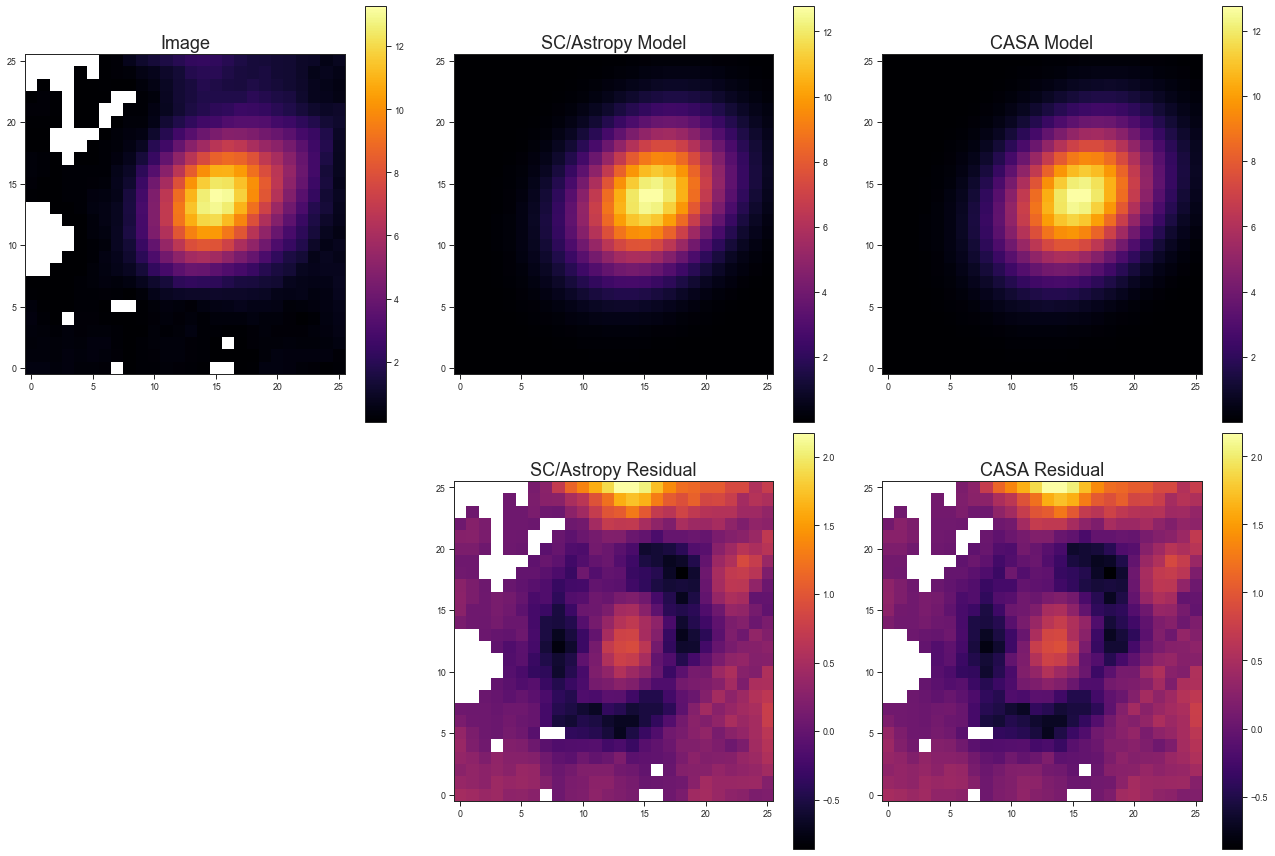

In [210]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.title("Image", fontsize=18)
plt.imshow(moment0_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()

# Model maps
plt.subplot(2, 3, 2)
plt.title("SC/Astropy Model", fontsize=18)
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(2, 3, 3)
plt.title("CASA Model", fontsize=18)
plt.imshow(g_casa_spatfit(xx_pix, yy_pix).value, origin='lower', cmap='inferno')
plt.colorbar()

# Residual maps
plt.subplot(2, 3, 5)
plt.title("SC/Astropy Residual", fontsize=18)
plt.imshow(moment0_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(2, 3, 6)
plt.title("CASA Residual", fontsize=18)
plt.imshow(moment0_cutout.value - g_casa_spatfit(xx_pix, yy_pix).value, origin='lower', cmap='inferno')
plt.colorbar()

plt.tight_layout()

The spectral-cube/astropy and CASA model results agree well. However, note that the position angle definition differs by $180^{\circ}$ between the two models. Because of this, the `x_stddev` and `y_stddev` differ between the models:

In [211]:
print(f"Amplitude: spectral-cube: {p_gauss2D.amplitude.quantity}, CASA: {g_casa_spatfit.amplitude.quantity}")
print(f"Major stddev: spectral-cube: {p_gauss2D.x_stddev.quantity.to(u.arcsec).value}, CASA: {g_casa_spatfit.y_stddev.value}")
print(f"Minor stddev: spectral-cube: {p_gauss2D.y_stddev.quantity.to(u.arcsec).value}, CASA: {g_casa_spatfit.x_stddev.value}")
print(f"Position angle: spectral-cube: {p_gauss2D.theta.quantity.to(u.deg)}, CASA: {g_casa_spatfit.theta.quantity.to(u.deg)}")

Amplitude: spectral-cube: 12.871325161920732 K km / s, CASA: 12.8383888569787 K km / s
Major stddev: spectral-cube: 4.927549702771874, CASA: 4.451009139383827
Minor stddev: spectral-cube: 3.6335649764546365, CASA: 3.4764324459573515
Position angle: spectral-cube: -26.70443925746928 deg, CASA: 132.2080778767417 deg


However, the evaluated models are essentially equivalent, as expected.

## Summary ##

This tutorial has covered how to make common moment maps in both CASA and spectral-cube. For operations on the small cube we used for this tutorial, both packages have similar performance.

When handling larger cubes, both CASA and spectral-cube will become limited by I/O (input/output) operations. When using spectral-cube, we recommend enabling dask operations to allow loading data in chunks with parallel processing. See the [documentation page](https://spectral-cube.readthedocs.io/en/latest/dask.html) on using dask in spectral-cube.